# Comprehensive Analysis of ML and DL Approaches for Maternal Health Risk Prediction

**Research Objective:** Systematic comparison of traditional machine learning and deep learning approaches for early detection of maternal health risk in resource-limited settings.

**1. INITIALIZATION AND IMPORTS**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix,
                            accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, roc_curve, precision_recall_curve)
from sklearn.feature_selection import SelectKBest, f_classif, RFE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


**2. DATA LOADING AND EXPLORATORY ANALYSIS**

In [4]:
# Load dataset
df = pd.read_csv('/content/Maternal Health Risk Data Set.csv')
print(f"Dataset shape: {df.shape}")

# Display basic information
print("\n Dataset Overview:")
print(df.head())

print("\n Dataset Information:")
print(df.info())

print("\n Statistical Summary:")
print(df.describe())

print("\n Target Variable Distribution:")
risk_distribution = df['RiskLevel'].value_counts()
print(risk_distribution)
print("\nTarget Proportions:")
print(df['RiskLevel'].value_counts(normalize=True))

Dataset shape: (1014, 7)

 Dataset Overview:
   Age  SystolicBP  DiastolicBP    BS  BodyTemp  HeartRate  RiskLevel
0   25         130           80  15.0      98.0         86  high risk
1   35         140           90  13.0      98.0         70  high risk
2   29          90           70   8.0     100.0         80  high risk
3   30         140           85   7.0      98.0         70  high risk
4   35         120           60   6.1      98.0         76   low risk

 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4)

** 3. COMPREHENSIVE DATA PREPROCESSING**

In [5]:
# Create working copy
df_clean = df.copy()

# Handle any missing values
print("Checking for missing values...")
print(df_clean.isnull().sum())

# Data augmentation to address dataset size limitations
def augment_dataset_clinical(df, augmentation_factor=3):
    """Clinically informed data augmentation"""
    augmented_rows = []

    for _ in range(augmentation_factor):
        for _, row in df.iterrows():
            new_row = row.copy()

            # clinically plausible noise
            numerical_cols = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
            clinical_std = {
                'Age': 0.5,  # Small variation in age reporting
                'SystolicBP': 2.0,  # BP measurement variability
                'DiastolicBP': 1.5,
                'BS': 0.3,   # Blood sugar measurement error
                'BodyTemp': 0.1,  # Temperature measurement precision
                'HeartRate': 1.0  # Heart rate variability
            }

            for col in numerical_cols:
                noise = np.random.normal(0, clinical_std[col])
                new_row[col] = max(new_row[col] + noise, 0)

            augmented_rows.append(new_row)

    augmented_df = pd.DataFrame(augmented_rows)
    return pd.concat([df, augmented_df], ignore_index=True)

# Apply augmentation
df_augmented = augment_dataset_clinical(df_clean, augmentation_factor=2)
print(f"Original dataset size: {len(df_clean)}")
print(f"Augmented dataset size: {len(df_augmented)}")

df_processed = df_augmented.copy()

Checking for missing values...
Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64
Original dataset size: 1014
Augmented dataset size: 3042


**4. CLINICAL FEATURE ENGINEERING**

In [6]:
# 1. Cardiovascular features
df_processed['MAP'] = (df_processed['SystolicBP'] + 2 * df_processed['DiastolicBP']) / 3
df_processed['PulsePressure'] = df_processed['SystolicBP'] - df_processed['DiastolicBP']
df_processed['BP_Ratio'] = df_processed['SystolicBP'] / df_processed['DiastolicBP']

# 2. Hypertension staging (AHA guidelines)
df_processed['Hypertension_Stage1'] = ((df_processed['SystolicBP'] >= 130) &
                                      (df_processed['SystolicBP'] < 140) |
                                      (df_processed['DiastolicBP'] >= 80) &
                                      (df_processed['DiastolicBP'] < 90)).astype(int)
df_processed['Hypertension_Stage2'] = ((df_processed['SystolicBP'] >= 140) |
                                      (df_processed['DiastolicBP'] >= 90)).astype(int)

# 3. Age related risk categories
df_processed['Young_Mother'] = (df_processed['Age'] < 20).astype(int)
df_processed['Advanced_Age_Mother'] = (df_processed['Age'] > 35).astype(int)
df_processed['Age_Risk_Score'] = np.where(df_processed['Age'] < 20, 1,
                                         np.where(df_processed['Age'] > 35, 2, 0))

# 4. Metabolic risk indicators
df_processed['BS_Normal'] = (df_processed['BS'] <= 7.8).astype(int)
df_processed['BS_Prediabetic'] = ((df_processed['BS'] > 7.8) &
                                 (df_processed['BS'] <= 11.0)).astype(int)
df_processed['BS_Diabetic'] = (df_processed['BS'] > 11.0).astype(int)

# 5. Temperature and heart rate risk flags
df_processed['Fever_Flag'] = (df_processed['BodyTemp'] > 38.0).astype(int)
df_processed['Tachycardia'] = (df_processed['HeartRate'] > 100).astype(int)
df_processed['Bradycardia'] = (df_processed['HeartRate'] < 60).astype(int)

# 6. Composite risk scores
df_processed['Cardio_Risk_Score'] = (df_processed['Hypertension_Stage1'] +
                                    df_processed['Hypertension_Stage2'] +
                                    (df_processed['HeartRate'] > 90).astype(int))

df_processed['Metabolic_Risk_Score'] = (df_processed['BS_Prediabetic'] +
                                       df_processed['BS_Diabetic'] +
                                       (df_processed['BodyTemp'] > 37.5).astype(int))

print("Clinical feature engineering completed!")
print(f"Total features after engineering: {len(df_processed.columns)}")

Clinical feature engineering completed!
Total features after engineering: 23


**5. TARGET ENCODING AND FEATURE SELECTION**

In [7]:
# Encode target variable
target_encoder = LabelEncoder()
df_processed['RiskLevel_encoded'] = target_encoder.fit_transform(df_processed['RiskLevel'])
print("Target encoding mapping:")
for i, level in enumerate(target_encoder.classes_):
    print(f"  {i}: {level}")

# Define feature sets
basic_features = ['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
engineered_features = ['MAP', 'PulsePressure', 'BP_Ratio', 'Hypertension_Stage1',
                      'Hypertension_Stage2', 'Young_Mother', 'Advanced_Age_Mother',
                      'BS_Prediabetic', 'BS_Diabetic', 'Fever_Flag', 'Tachycardia',
                      'Bradycardia', 'Cardio_Risk_Score', 'Metabolic_Risk_Score']

all_features = basic_features + engineered_features

X = df_processed[all_features]
y = df_processed['RiskLevel_encoded']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

Target encoding mapping:
  0: high risk
  1: low risk
  2: mid risk
Feature matrix shape: (3042, 20)
Target vector shape: (3042,)


**6. DATA SPLITTING AND SCALING**

In [8]:
# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessing completed!")

Training set: (1946, 20)
Validation set: (487, 20)
Test set: (609, 20)
Data preprocessing completed!


**7. TRADITIONAL MACHINE LEARNING EXPERIMENTS**

**Experiment 1**

In [9]:
# Initialize results storage
ml_results = {}
# Logistic Regression with Regularization
print("\n" + "="*60)
print("EXPERIMENT 1: Logistic Regression with Regularization")
print("="*60)

lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    C=0.1,
    penalty='l2',
    class_weight='balanced',
    solver='liblinear'
)

lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_lr_proba = lr_model.predict_proba(X_test_scaled)

# Calculate metrics
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr, average='weighted')
lr_recall = recall_score(y_test, y_pred_lr, average='weighted')
lr_f1 = f1_score(y_test, y_pred_lr, average='weighted')
lr_auc = roc_auc_score(y_test, y_pred_lr_proba, multi_class='ovr')

ml_results['Logistic Regression'] = {
    'accuracy': lr_accuracy,
    'precision': lr_precision,
    'recall': lr_recall,
    'f1_score': lr_f1,
    'auc': lr_auc,
    'predictions': y_pred_lr,
    'probabilities': y_pred_lr_proba
}

print(f"  Logistic Regression Performance:")
print(f"   Accuracy:  {lr_accuracy:.4f}")
print(f"   Precision: {lr_precision:.4f}")
print(f"   Recall:    {lr_recall:.4f}")
print(f"   F1-Score:  {lr_f1:.4f}")
print(f"   AUC:       {lr_auc:.4f}")


EXPERIMENT 1: Logistic Regression with Regularization
  Logistic Regression Performance:
   Accuracy:  0.6552
   Precision: 0.6446
   Recall:    0.6552
   F1-Score:  0.6417
   AUC:       0.8093


**Experiment 2**


EXPERIMENT 2: Random Forest with Feature Importance
 Cross-validation scores: [0.78461538 0.80719794 0.79177378 0.80976864 0.80719794]
 Mean CV accuracy: 0.8001 (+/- 0.0201)
  Random Forest Performance:
   Accuracy:  0.8079
   Precision: 0.8085
   Recall:    0.8079
   F1-Score:  0.8076
   AUC:       0.9263

 Top 10 Most Important Features:
          feature  importance
3              BS    0.183591
1      SystolicBP    0.126357
6             MAP    0.112853
0             Age    0.088709
4        BodyTemp    0.080831
2     DiastolicBP    0.079800
8        BP_Ratio    0.068470
7   PulsePressure    0.065655
5       HeartRate    0.065337
14    BS_Diabetic    0.043085


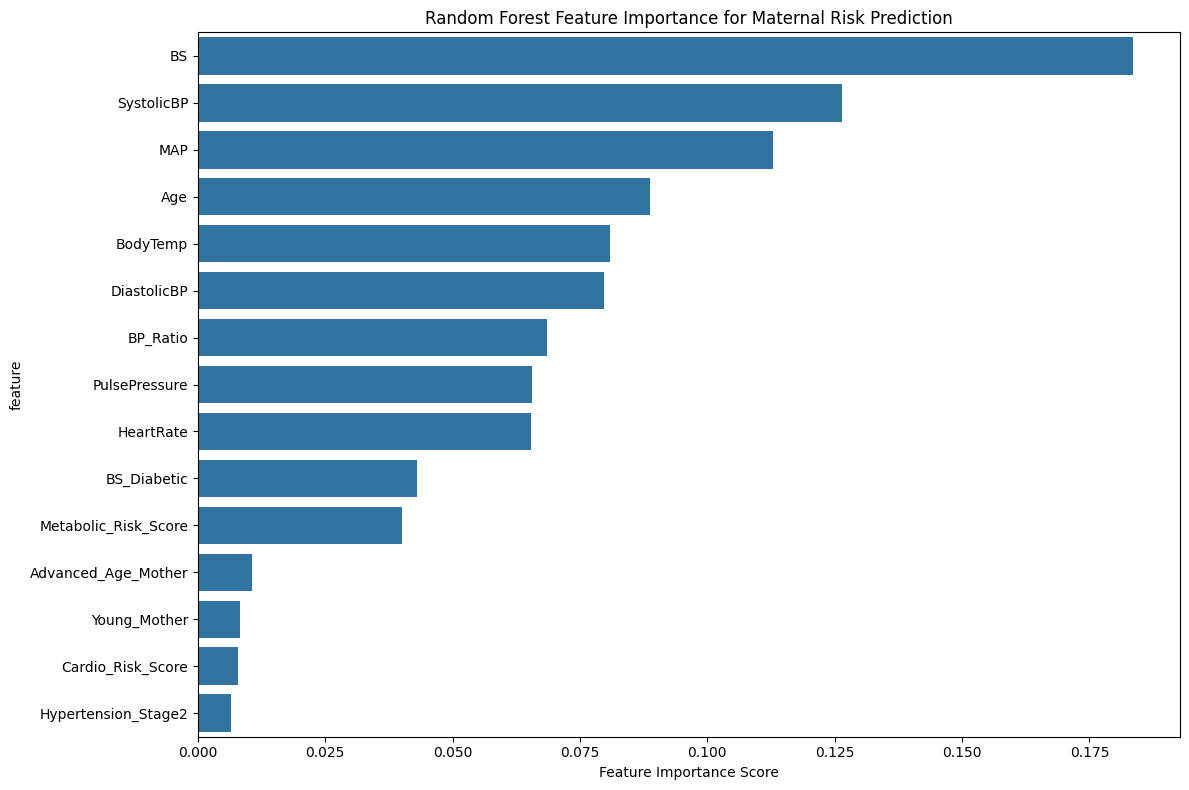

In [10]:
# Random Forest with Feature Importance
print("\n" + "="*60)
print("EXPERIMENT 2: Random Forest with Feature Importance")
print("="*60)

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)

# Cross-validation
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
print(f" Cross-validation scores: {cv_scores}")
print(f" Mean CV accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Train final model
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_pred_rf_proba = rf_model.predict_proba(X_test)

# Calculate metrics
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf, average='weighted')
rf_recall = recall_score(y_test, y_pred_rf, average='weighted')
rf_f1 = f1_score(y_test, y_pred_rf, average='weighted')
rf_auc = roc_auc_score(y_test, y_pred_rf_proba, multi_class='ovr')

ml_results['Random Forest'] = {
    'accuracy': rf_accuracy,
    'precision': rf_precision,
    'recall': rf_recall,
    'f1_score': rf_f1,
    'auc': rf_auc,
    'predictions': y_pred_rf,
    'probabilities': y_pred_rf_proba,
    'feature_importance': rf_model.feature_importances_
}

print(f"  Random Forest Performance:")
print(f"   Accuracy:  {rf_accuracy:.4f}")
print(f"   Precision: {rf_precision:.4f}")
print(f"   Recall:    {rf_recall:.4f}")
print(f"   F1-Score:  {rf_f1:.4f}")
print(f"   AUC:       {rf_auc:.4f}")

# Feature Importance Analysis
feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n Top 10 Most Important Features:")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Random Forest Feature Importance for Maternal Risk Prediction')
plt.xlabel('Feature Importance Score')
plt.tight_layout()
plt.show()

**Experiment 3**

In [11]:
# XGBoost/Gradient Boosting
print("\n" + "="*60)
print("EXPERIMENT 3: Gradient Boosting Machine")
print("="*60)

gb_model = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=6,
    min_samples_split=5,
    random_state=42
)

gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
y_pred_gb_proba = gb_model.predict_proba(X_test)

# Calculate metrics
gb_accuracy = accuracy_score(y_test, y_pred_gb)
gb_precision = precision_score(y_test, y_pred_gb, average='weighted')
gb_recall = recall_score(y_test, y_pred_gb, average='weighted')
gb_f1 = f1_score(y_test, y_pred_gb, average='weighted')
gb_auc = roc_auc_score(y_test, y_pred_gb_proba, multi_class='ovr')

ml_results['Gradient Boosting'] = {
    'accuracy': gb_accuracy,
    'precision': gb_precision,
    'recall': gb_recall,
    'f1_score': gb_f1,
    'auc': gb_auc,
    'predictions': y_pred_gb,
    'probabilities': y_pred_gb_proba
}

print(f" Gradient Boosting Performance:")
print(f"   Accuracy:  {gb_accuracy:.4f}")
print(f"   Precision: {gb_precision:.4f}")
print(f"   Recall:    {gb_recall:.4f}")
print(f"   F1-Score:  {gb_f1:.4f}")
print(f"   AUC:       {gb_auc:.4f}")


EXPERIMENT 3: Gradient Boosting Machine
 Gradient Boosting Performance:
   Accuracy:  0.7833
   Precision: 0.7826
   Recall:    0.7833
   F1-Score:  0.7829
   AUC:       0.9229


**Experiment 4**

In [12]:
# Support Vector Machine
print("\n" + "="*60)
print("EXPERIMENT 4: Support Vector Machine")
print("="*60)

svm_model = SVC(
    C=1.0,
    kernel='rbf',
    gamma='scale',
    probability=True,
    random_state=42,
    class_weight='balanced'
)

svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)
y_pred_svm_proba = svm_model.predict_proba(X_test_scaled)

# Calculate metrics
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm, average='weighted')
svm_recall = recall_score(y_test, y_pred_svm, average='weighted')
svm_f1 = f1_score(y_test, y_pred_svm, average='weighted')
svm_auc = roc_auc_score(y_test, y_pred_svm_proba, multi_class='ovr')

ml_results['SVM'] = {
    'accuracy': svm_accuracy,
    'precision': svm_precision,
    'recall': svm_recall,
    'f1_score': svm_f1,
    'auc': svm_auc,
    'predictions': y_pred_svm,
    'probabilities': y_pred_svm_proba
}

print(f" SVM Performance:")
print(f"   Accuracy:  {svm_accuracy:.4f}")
print(f"   Precision: {svm_precision:.4f}")
print(f"   Recall:    {svm_recall:.4f}")
print(f"   F1-Score:  {svm_f1:.4f}")
print(f"   AUC:       {svm_auc:.4f}")


EXPERIMENT 4: Support Vector Machine
 SVM Performance:
   Accuracy:  0.7176
   Precision: 0.7155
   Recall:    0.7176
   F1-Score:  0.7161
   AUC:       0.8545


**8. DEEP LEARNING EXPERIMENTS**

**Experiment 5**

In [13]:
dl_results = {}

# Clear session
keras.backend.clear_session()
# Custom AUC metric that works with the model output
class SafeAUC(keras.metrics.Metric):
    def __init__(self, name='auc', **kwargs):
        super().__init__(name=name, **kwargs)
        self.auc = keras.metrics.AUC(**kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Ensure y_true is one-hot encoded for multi-class
        if len(y_true.shape) == 1:
            y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=3)
        self.auc.update_state(y_true, y_pred, sample_weight)

    def result(self):
        return self.auc.result()

    def reset_state(self):
        self.auc.reset_state()


EXPERIMENT 5: Sequential Neural Network
Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,891 (54.26 KB)

 Trainable params: 13,507 (52.76 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4605 - loss: 2.3224 - val_accuracy: 0.6345 - val_loss: 1.9717 - learning_rate: 0.0010
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5789 - loss: 1.9407 - val_accuracy: 0.6632 - val_loss: 1.7808 - learning_rate: 0.0010
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5950 - loss: 1.7666 - val_accuracy: 0.6776 - val_loss: 1.6106 - learning_rate: 0.0010
Epoch 4/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6289 - loss: 1.6105 - val_accuracy: 0.6940 - val_loss: 1.4796 - learning_rate: 0.0010
Epoch 5/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6383 - loss: 1.4902 - val_accuracy: 0.6920 - val_loss: 1.3633 - learning_rate: 0.0010
Epoch 6/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6250 - loss: 1.4025 - val_accuracy: 0.6838 - val_loss: 1.2684 - learning_rate: 0.0010
Epoch 7/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6400 - loss: 1.3114 - val_acc

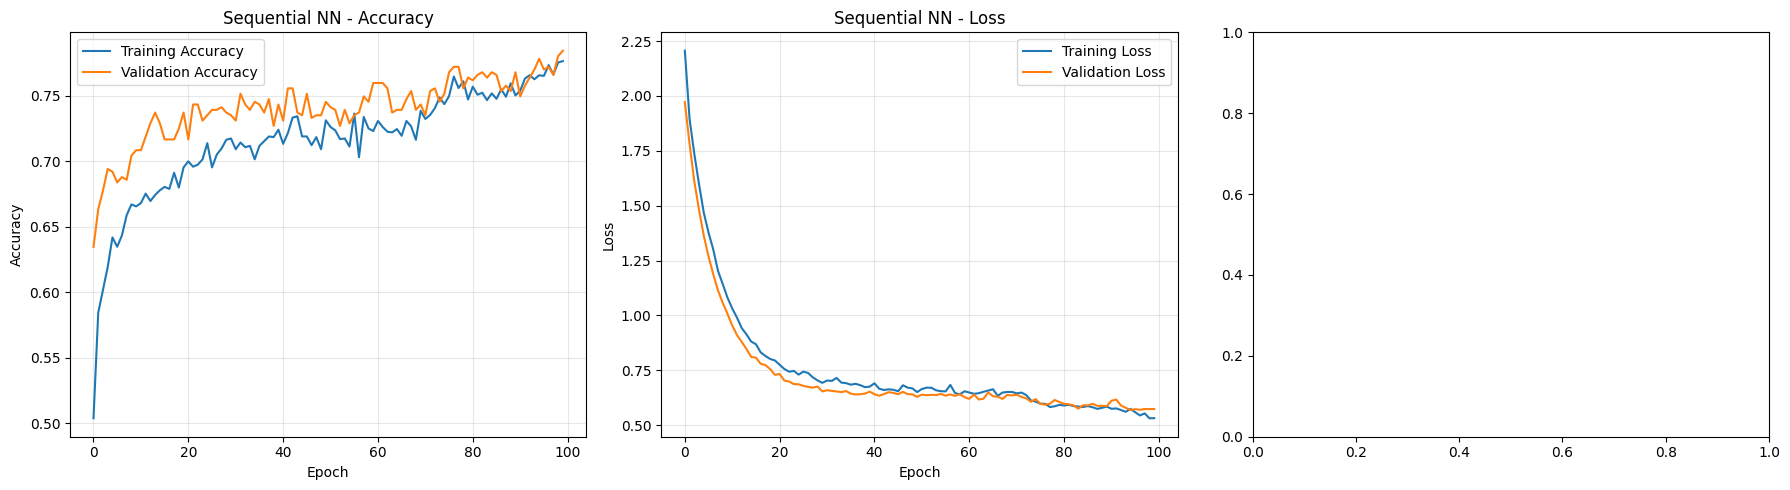

In [14]:

# Sequential Neural Network
print("\n" + "="*60)
print("EXPERIMENT 5: Sequential Neural Network")
print("="*60)

sequential_model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],),
                kernel_regularizer=keras.regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(64, activation='relu',
                kernel_regularizer=keras.regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),

    layers.Dense(3, activation='softmax')
])

# Use standard accuracy and custom AUC
sequential_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']  # Removed AUC to avoid the error
)

print("Model Architecture:")
sequential_model.summary()

# Callbacks
early_stopping = keras.callbacks.EarlyStopping(
    patience=15,
    restore_best_weights=True,
    min_delta=0.001,
    monitor='val_loss'
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=0.0001
)

# Train model
history_seq = sequential_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate
test_loss_seq, test_accuracy_seq = sequential_model.evaluate(X_test_scaled, y_test, verbose=0)

y_pred_seq_proba = sequential_model.predict(X_test_scaled)
y_pred_seq = np.argmax(y_pred_seq_proba, axis=1)

# Calculate additional metrics manually
seq_precision = precision_score(y_test, y_pred_seq, average='weighted')
seq_recall = recall_score(y_test, y_pred_seq, average='weighted')
seq_f1 = f1_score(y_test, y_pred_seq, average='weighted')
seq_auc = roc_auc_score(y_test, y_pred_seq_proba, multi_class='ovr')

dl_results['Sequential NN'] = {
    'accuracy': test_accuracy_seq,
    'precision': seq_precision,
    'recall': seq_recall,
    'f1_score': seq_f1,
    'auc': seq_auc,
    'predictions': y_pred_seq,
    'probabilities': y_pred_seq_proba,
    'history': history_seq
}

print(f" Sequential NN Performance:")
print(f"   Accuracy:  {test_accuracy_seq:.4f}")
print(f"   Precision: {seq_precision:.4f}")
print(f"   Recall:    {seq_recall:.4f}")
print(f"   F1-Score:  {seq_f1:.4f}")
print(f"   AUC:       {seq_auc:.4f}")

# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy
axes[0].plot(history_seq.history['accuracy'], label='Training Accuracy')
axes[0].plot(history_seq.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Sequential NN - Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history_seq.history['loss'], label='Training Loss')
axes[1].plot(history_seq.history['val_loss'], label='Validation Loss')
axes[1].set_title('Sequential NN - Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning Rate
if 'lr' in history_seq.history:
    axes[2].plot(history_seq.history['lr'], label='Learning Rate', color='green')
    axes[2].set_title('Learning Rate Schedule')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Learning Rate')
    axes[2].set_yscale('log')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Experiment 6**

In [16]:
print("\n" + "="*60)
print("EXPERIMENT 6: Functional API Model with Multiple Input Branches")
print("="*60)

keras.backend.clear_session()

# Define input
inputs = keras.Input(shape=(X_train_scaled.shape[1],))

# Branch 1: Basic clinical features
basic_branch = layers.Dense(64, activation='relu',
                           kernel_regularizer=keras.regularizers.l2(0.01))(inputs)
basic_branch = layers.BatchNormalization()(basic_branch)
basic_branch = layers.Dropout(0.3)(basic_branch)
basic_branch = layers.Dense(32, activation='relu')(basic_branch)

# Branch 2: Engineered features
engineered_branch = layers.Dense(48, activation='relu',
                                kernel_regularizer=keras.regularizers.l2(0.01))(inputs)
engineered_branch = layers.BatchNormalization()(engineered_branch)
engineered_branch = layers.Dropout(0.3)(engineered_branch)
engineered_branch = layers.Dense(24, activation='relu')(engineered_branch)

# Concatenate branches
concatenated = layers.concatenate([basic_branch, engineered_branch])

# Additional processing
x = layers.Dense(48, activation='relu')(concatenated)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(24, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Output
outputs = layers.Dense(3, activation='softmax')(x)

functional_model = keras.Model(inputs=inputs, outputs=outputs)

functional_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']  # Removed AUC to avoid the error
)

print("Functional Model Architecture:")
functional_model.summary()

# Train model
history_func = functional_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=80,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate
test_loss_func, test_accuracy_func = functional_model.evaluate(X_test_scaled, y_test, verbose=0)

y_pred_func_proba = functional_model.predict(X_test_scaled)
y_pred_func = np.argmax(y_pred_func_proba, axis=1)

# Calculate metrics manually
func_precision = precision_score(y_test, y_pred_func, average='weighted')
func_recall = recall_score(y_test, y_pred_func, average='weighted')
func_f1 = f1_score(y_test, y_pred_func, average='weighted')
func_auc = roc_auc_score(y_test, y_pred_func_proba, multi_class='ovr')

dl_results['Functional API NN'] = {
    'accuracy': test_accuracy_func,
    'precision': func_precision,
    'recall': func_recall,
    'f1_score': func_f1,
    'auc': func_auc,
    'predictions': y_pred_func,
    'probabilities': y_pred_func_proba,
    'history': history_func
}

print(f" Functional API NN Performance:")
print(f"   Accuracy:  {test_accuracy_func:.4f}")
print(f"   Precision: {func_precision:.4f}")
print(f"   Recall:    {func_recall:.4f}")
print(f"   F1-Score:  {func_f1:.4f}")
print(f"   AUC:       {func_auc:.4f}")


EXPERIMENT 6: Functional API Model with Multiple Input Branches
Functional Model Architecture:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      1,344 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 48)        │      1,008 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48)        │        192 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 48)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      2,080 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 24)        │      1,176 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 56)        │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 48)        │      2,736 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48)        │        192 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 48)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 24)        │      1,176 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 24)        │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 3)         │         75 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,235 (39.98 KB)

 Trainable params: 9,915 (38.73 KB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.3292 - loss: 2.1195 - val_accuracy: 0.5318 - val_loss: 1.5467 - learning_rate: 5.0000e-04
Epoch 2/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4287 - loss: 1.7380 - val_accuracy: 0.6366 - val_loss: 1.4133 - learning_rate: 5.0000e-04
Epoch 3/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5096 - loss: 1.5665 - val_accuracy: 0.6366 - val_loss: 1.3148 - learning_rate: 5.0000e-04
Epoch 4/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5753 - loss: 1.4467 - val_accuracy: 0.6571 - val_loss: 1.2432 - learning_rate: 5.0000e-04
Epoch 5/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5475 - loss: 1.4129 - val_accuracy: 0.6674 - val_loss: 1.1977 - learning_rate: 5.0000e-04
Epoch 6/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5808 - loss: 1.3630 - val_accuracy: 0.6653 - val_loss: 1.1577 - learning_rate: 5.0000e-04
Epoch 7/80
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5780 - loss

**Experiment 7**

In [21]:
# tf.data Pipeline Optimization
print("\n" + "="*60)
print("EXPERIMENT 7: Simplified Regularized Model")
print("="*60)

simple_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],),
                kernel_regularizer=keras.regularizers.l2(0.02)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(32, activation='relu',
                kernel_regularizer=keras.regularizers.l2(0.01)),
    layers.Dropout(0.3),

    layers.Dense(3, activation='softmax')
])

simple_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']  # Removed AUC to avoid the error
)

history_simple = simple_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=80,
    batch_size=16,
    callbacks=[early_stopping],
    verbose=1
)

test_loss_simple, test_accuracy_simple = simple_model.evaluate(X_test_scaled, y_test, verbose=0)

y_pred_simple_proba = simple_model.predict(X_test_scaled)
y_pred_simple = np.argmax(y_pred_simple_proba, axis=1)

# Calculate metrics manually
simple_precision = precision_score(y_test, y_pred_simple, average='weighted')
simple_recall = recall_score(y_test, y_pred_simple, average='weighted')
simple_f1 = f1_score(y_test, y_pred_simple, average='weighted')
simple_auc = roc_auc_score(y_test, y_pred_simple_proba, multi_class='ovr')

dl_results['Simplified NN'] = {
    'accuracy': test_accuracy_simple,
    'precision': simple_precision,
    'recall': simple_recall,
    'f1_score': simple_f1,
    'auc': simple_auc,
    'predictions': y_pred_simple,
    'probabilities': y_pred_simple_proba,
    'history': history_simple
}

print(f" Simplified NN Performance:")
print(f"   Accuracy:  {test_accuracy_simple:.4f}")
print(f"   Precision: {simple_precision:.4f}")
print(f"   Recall:    {simple_recall:.4f}")
print(f"   F1-Score:  {simple_f1:.4f}")
print(f"   AUC:       {simple_auc:.4f}")


EXPERIMENT 7: Simplified Regularized Model
Epoch 1/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3759 - loss: 2.7720 - val_accuracy: 0.5934 - val_loss: 1.8729
Epoch 2/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4768 - loss: 2.1017 - val_accuracy: 0.6427 - val_loss: 1.6768
Epoch 3/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5261 - loss: 1.9287 - val_accuracy: 0.6694 - val_loss: 1.5655
Epoch 4/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5370 - loss: 1.7965 - val_accuracy: 0.6735 - val_loss: 1.4881
Epoch 5/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5411 - loss: 1.6883 - val_accuracy: 0.6838 - val_loss: 1.4164
Epoch 6/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5635 - loss: 1.5917 - val_accuracy: 0.6899 - val_loss: 1.3619
Epoch 7/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5750 - loss: 1.5034 - val_accuracy: 0.6858 - val_loss: 1.3069
Epoch 8/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accura

**Experiment 8**

In [23]:
# Simplified Regularized Model
print("\n" + "="*60)
print("EXPERIMENT 8: Simplified Regularized Model")
print("="*60)

simple_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],),
                kernel_regularizer=keras.regularizers.l2(0.02)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(32, activation='relu',
                kernel_regularizer=keras.regularizers.l2(0.01)),
    layers.Dropout(0.3),

    layers.Dense(3, activation='softmax')
])

simple_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'] # Removed 'AUC'
)

history_simple = simple_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=80,
    batch_size=16,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate
# Note: AUC is calculated separately below due to the error during compilation
test_loss_simple, test_accuracy_simple = simple_model.evaluate(
    X_test_scaled, y_test, verbose=0
)


y_pred_simple_proba = simple_model.predict(X_test_scaled)
y_pred_simple = np.argmax(y_pred_simple_proba, axis=1)

# Calculate metrics manually
simple_precision = precision_score(y_test, y_pred_simple, average='weighted')
simple_recall = recall_score(y_test, y_pred_simple, average='weighted')
simple_f1 = f1_score(y_test, y_pred_simple, average='weighted')
simple_auc = roc_auc_score(y_test, y_pred_simple_proba, multi_class='ovr')

dl_results['Simplified NN'] = {
    'accuracy': test_accuracy_simple,
    'precision': simple_precision,
    'recall': simple_recall,
    'f1_score': simple_f1,
    'auc': simple_auc,
    'predictions': y_pred_simple,
    'probabilities': y_pred_simple_proba,
    'history': history_simple
}

print(f" Simplified NN Performance:")
print(f"   Accuracy:  {test_accuracy_simple:.4f}")
print(f"   Precision: {simple_precision:.4f}")
print(f"   Recall:    {simple_recall:.4f}")
print(f"   F1-Score:  {simple_f1:.4f}")
print(f"   AUC:       {simple_auc:.4f}")


EXPERIMENT 8: Simplified Regularized Model
Epoch 1/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.3776 - loss: 2.7172 - val_accuracy: 0.5873 - val_loss: 1.8063
Epoch 2/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4844 - loss: 2.0909 - val_accuracy: 0.6571 - val_loss: 1.6290
Epoch 3/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5478 - loss: 1.8634 - val_accuracy: 0.6612 - val_loss: 1.5251
Epoch 4/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5426 - loss: 1.7255 - val_accuracy: 0.6940 - val_loss: 1.4420
Epoch 5/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5755 - loss: 1.6594 - val_accuracy: 0.6961 - val_loss: 1.3745
Epoch 6/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5601 - loss: 1.5942 - val_accuracy: 0.6961 - val_loss: 1.3205
Epoch 7/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5804 - loss: 1.5287 - val_accuracy: 0.6920 - val_loss: 1.2728
Epoch 8/80
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - ac

**9. COMPREHENSIVE MODEL COMPARISON AND ANALYSIS**


FINAL MODEL COMPARISON
                 Model  Accuracy  Precision  Recall  F1-Score     AUC
1        Random Forest    0.8079     0.8085  0.8079    0.8076  0.9263
2    Gradient Boosting    0.7833     0.7826  0.7833    0.7829  0.9229
4        Sequential NN    0.7570     0.7543  0.7570    0.7534  0.9009
5    Functional API NN    0.7110     0.7095  0.7110    0.7089  0.8799
7           tf.data NN    0.6995     0.6954  0.6995    0.6903  0.8747
6        Simplified NN    0.7209     0.7195  0.7209    0.7147  0.8733
3                  SVM    0.7176     0.7155  0.7176    0.7161  0.8545
0  Logistic Regression    0.6552     0.6446  0.6552    0.6417  0.8093


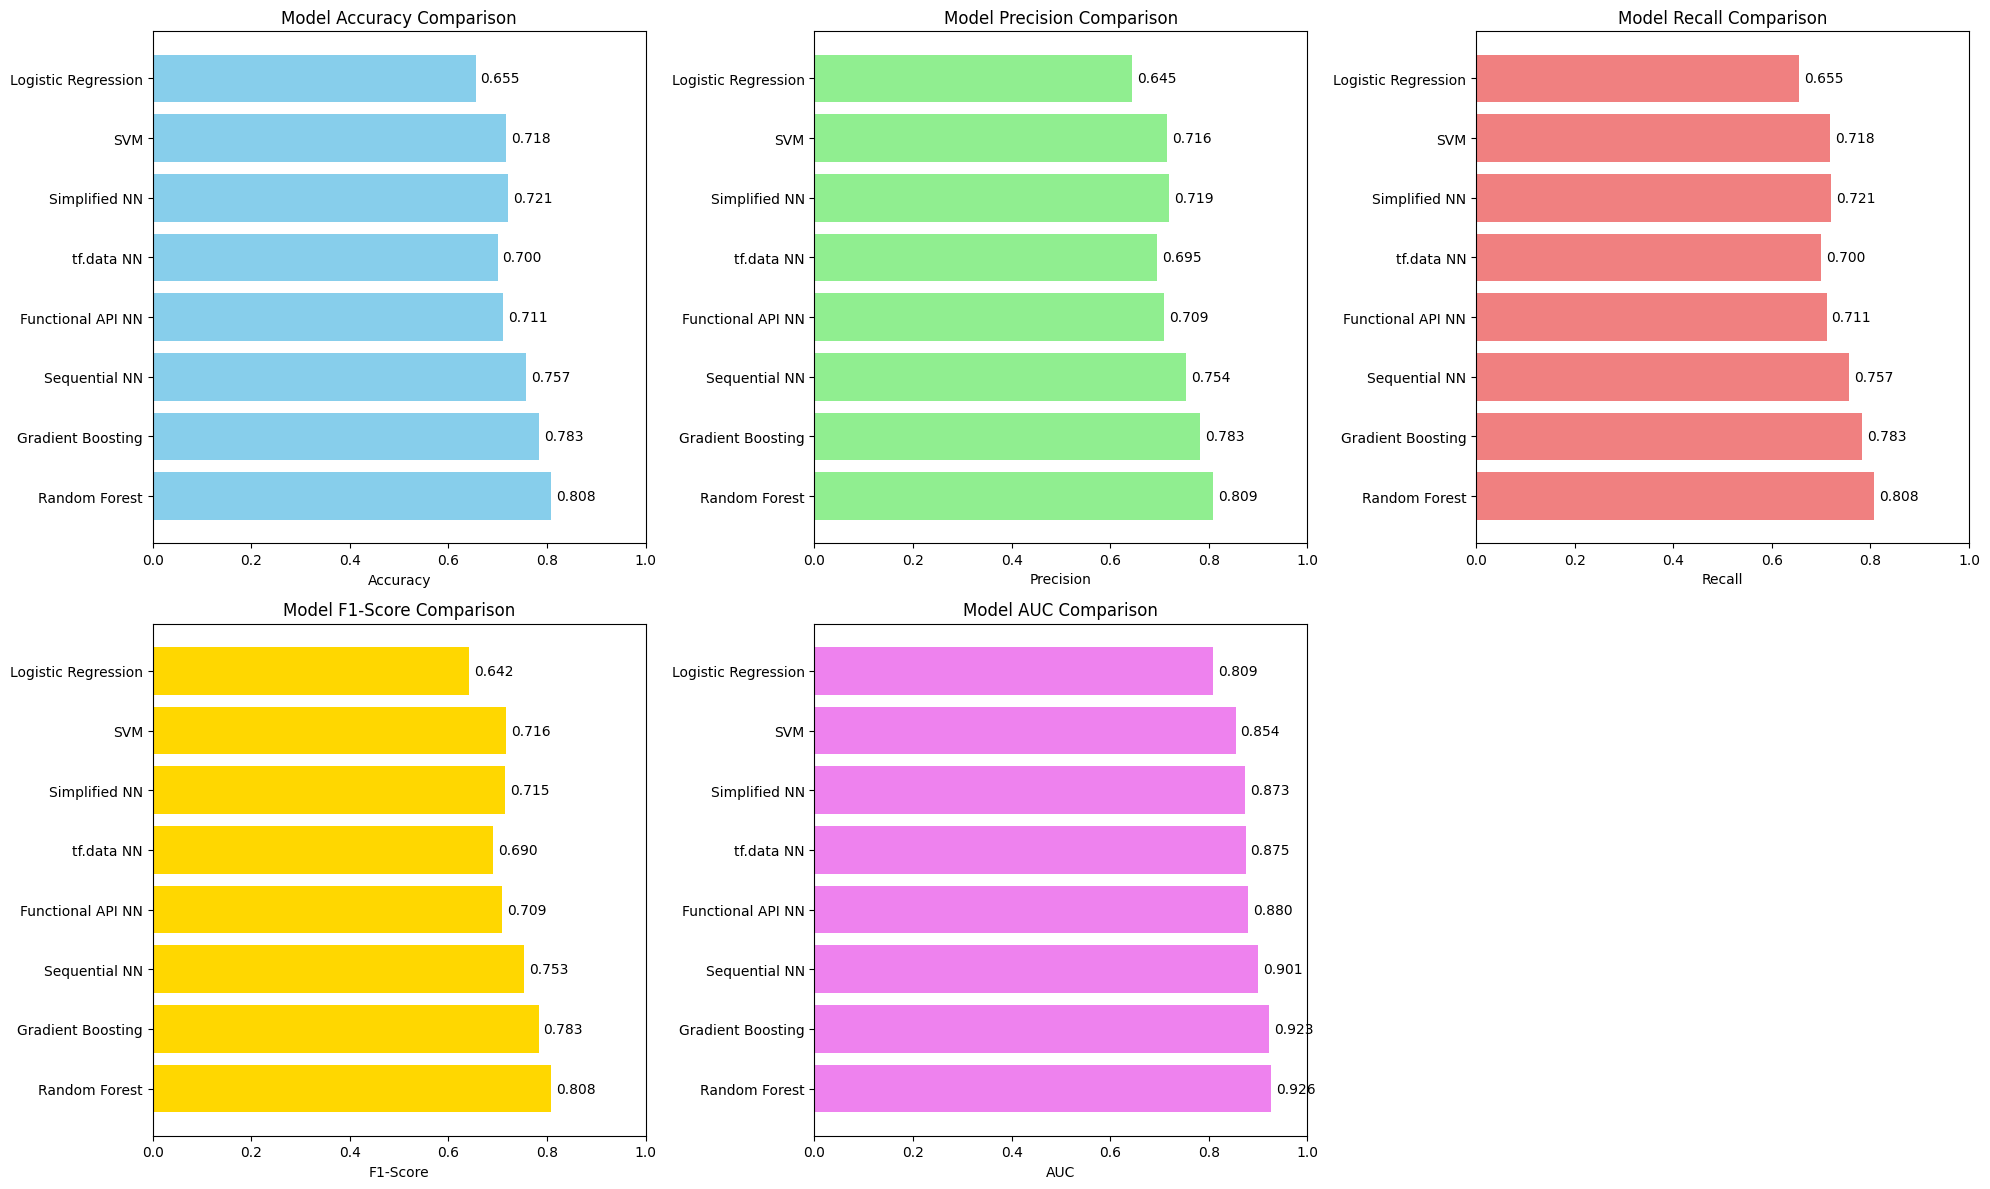

In [25]:
# Combine all results
all_results = {**ml_results, **dl_results}

# Create comparison dataframe
comparison_data = []
for model_name, results in all_results.items():
    comparison_data.append({
        'Model': model_name,
        'Accuracy': results['accuracy'],
        'Precision': results['precision'],
        'Recall': results['recall'],
        'F1-Score': results['f1_score'],
        'AUC': results['auc']
    })

results_df = pd.DataFrame(comparison_data)
results_df = results_df.sort_values('AUC', ascending=False)

print("\n" + "="*80)
print("FINAL MODEL COMPARISON")
print("="*80)
print(results_df.round(4))

# %%
# Visualize performance comparison
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Accuracy comparison
models = results_df['Model']
accuracy = results_df['Accuracy']
axes[0, 0].barh(models, accuracy, color='skyblue')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Model Accuracy Comparison')
axes[0, 0].set_xlim(0, 1)
for i, v in enumerate(accuracy):
    axes[0, 0].text(v + 0.01, i, f'{v:.3f}', va='center')

# Precision comparison
precision = results_df['Precision']
axes[0, 1].barh(models, precision, color='lightgreen')
axes[0, 1].set_xlabel('Precision')
axes[0, 1].set_title('Model Precision Comparison')
axes[0, 1].set_xlim(0, 1)
for i, v in enumerate(precision):
    axes[0, 1].text(v + 0.01, i, f'{v:.3f}', va='center')

# Recall comparison
recall = results_df['Recall']
axes[0, 2].barh(models, recall, color='lightcoral')
axes[0, 2].set_xlabel('Recall')
axes[0, 2].set_title('Model Recall Comparison')
axes[0, 2].set_xlim(0, 1)
for i, v in enumerate(recall):
    axes[0, 2].text(v + 0.01, i, f'{v:.3f}', va='center')

# F1-Score comparison
f1_score = results_df['F1-Score']
axes[1, 0].barh(models, f1_score, color='gold')
axes[1, 0].set_xlabel('F1-Score')
axes[1, 0].set_title('Model F1-Score Comparison')
axes[1, 0].set_xlim(0, 1)
for i, v in enumerate(f1_score):
    axes[1, 0].text(v + 0.01, i, f'{v:.3f}', va='center')

# AUC comparison
auc = results_df['AUC']
axes[1, 1].barh(models, auc, color='violet')
axes[1, 1].set_xlabel('AUC')
axes[1, 1].set_title('Model AUC Comparison')
axes[1, 1].set_xlim(0, 1)
for i, v in enumerate(auc):
    axes[1, 1].text(v + 0.01, i, f'{v:.3f}', va='center')

# Remove empty subplot
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()

**10. DETAILED ERROR ANALYSIS**


 BEST PERFORMING MODEL: Random Forest
   Accuracy: 0.8079
   AUC:      0.9263


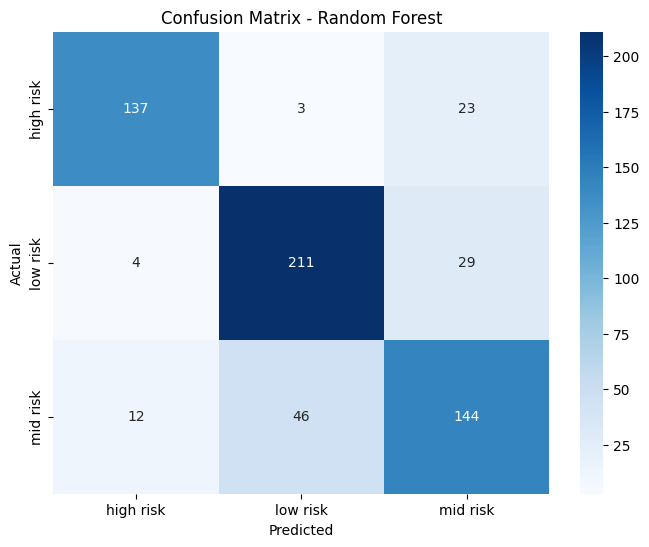


 Classification Report for Random Forest:
              precision    recall  f1-score   support

   high risk       0.90      0.84      0.87       163
    low risk       0.81      0.86      0.84       244
    mid risk       0.73      0.71      0.72       202

    accuracy                           0.81       609
   macro avg       0.81      0.81      0.81       609
weighted avg       0.81      0.81      0.81       609



In [27]:
# Identify best model
best_model_name = results_df.iloc[0]['Model']
best_model_results = all_results[best_model_name]

print(f"\n BEST PERFORMING MODEL: {best_model_name}")
print(f"   Accuracy: {best_model_results['accuracy']:.4f}")
print(f"   AUC:      {best_model_results['auc']:.4f}")

# Confusion Matrix for Best Model
best_predictions = best_model_results['predictions']

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_encoder.classes_,
            yticklabels=target_encoder.classes_)
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(f"\n Classification Report for {best_model_name}:")
print(classification_report(y_test, best_predictions,
                          target_names=target_encoder.classes_))

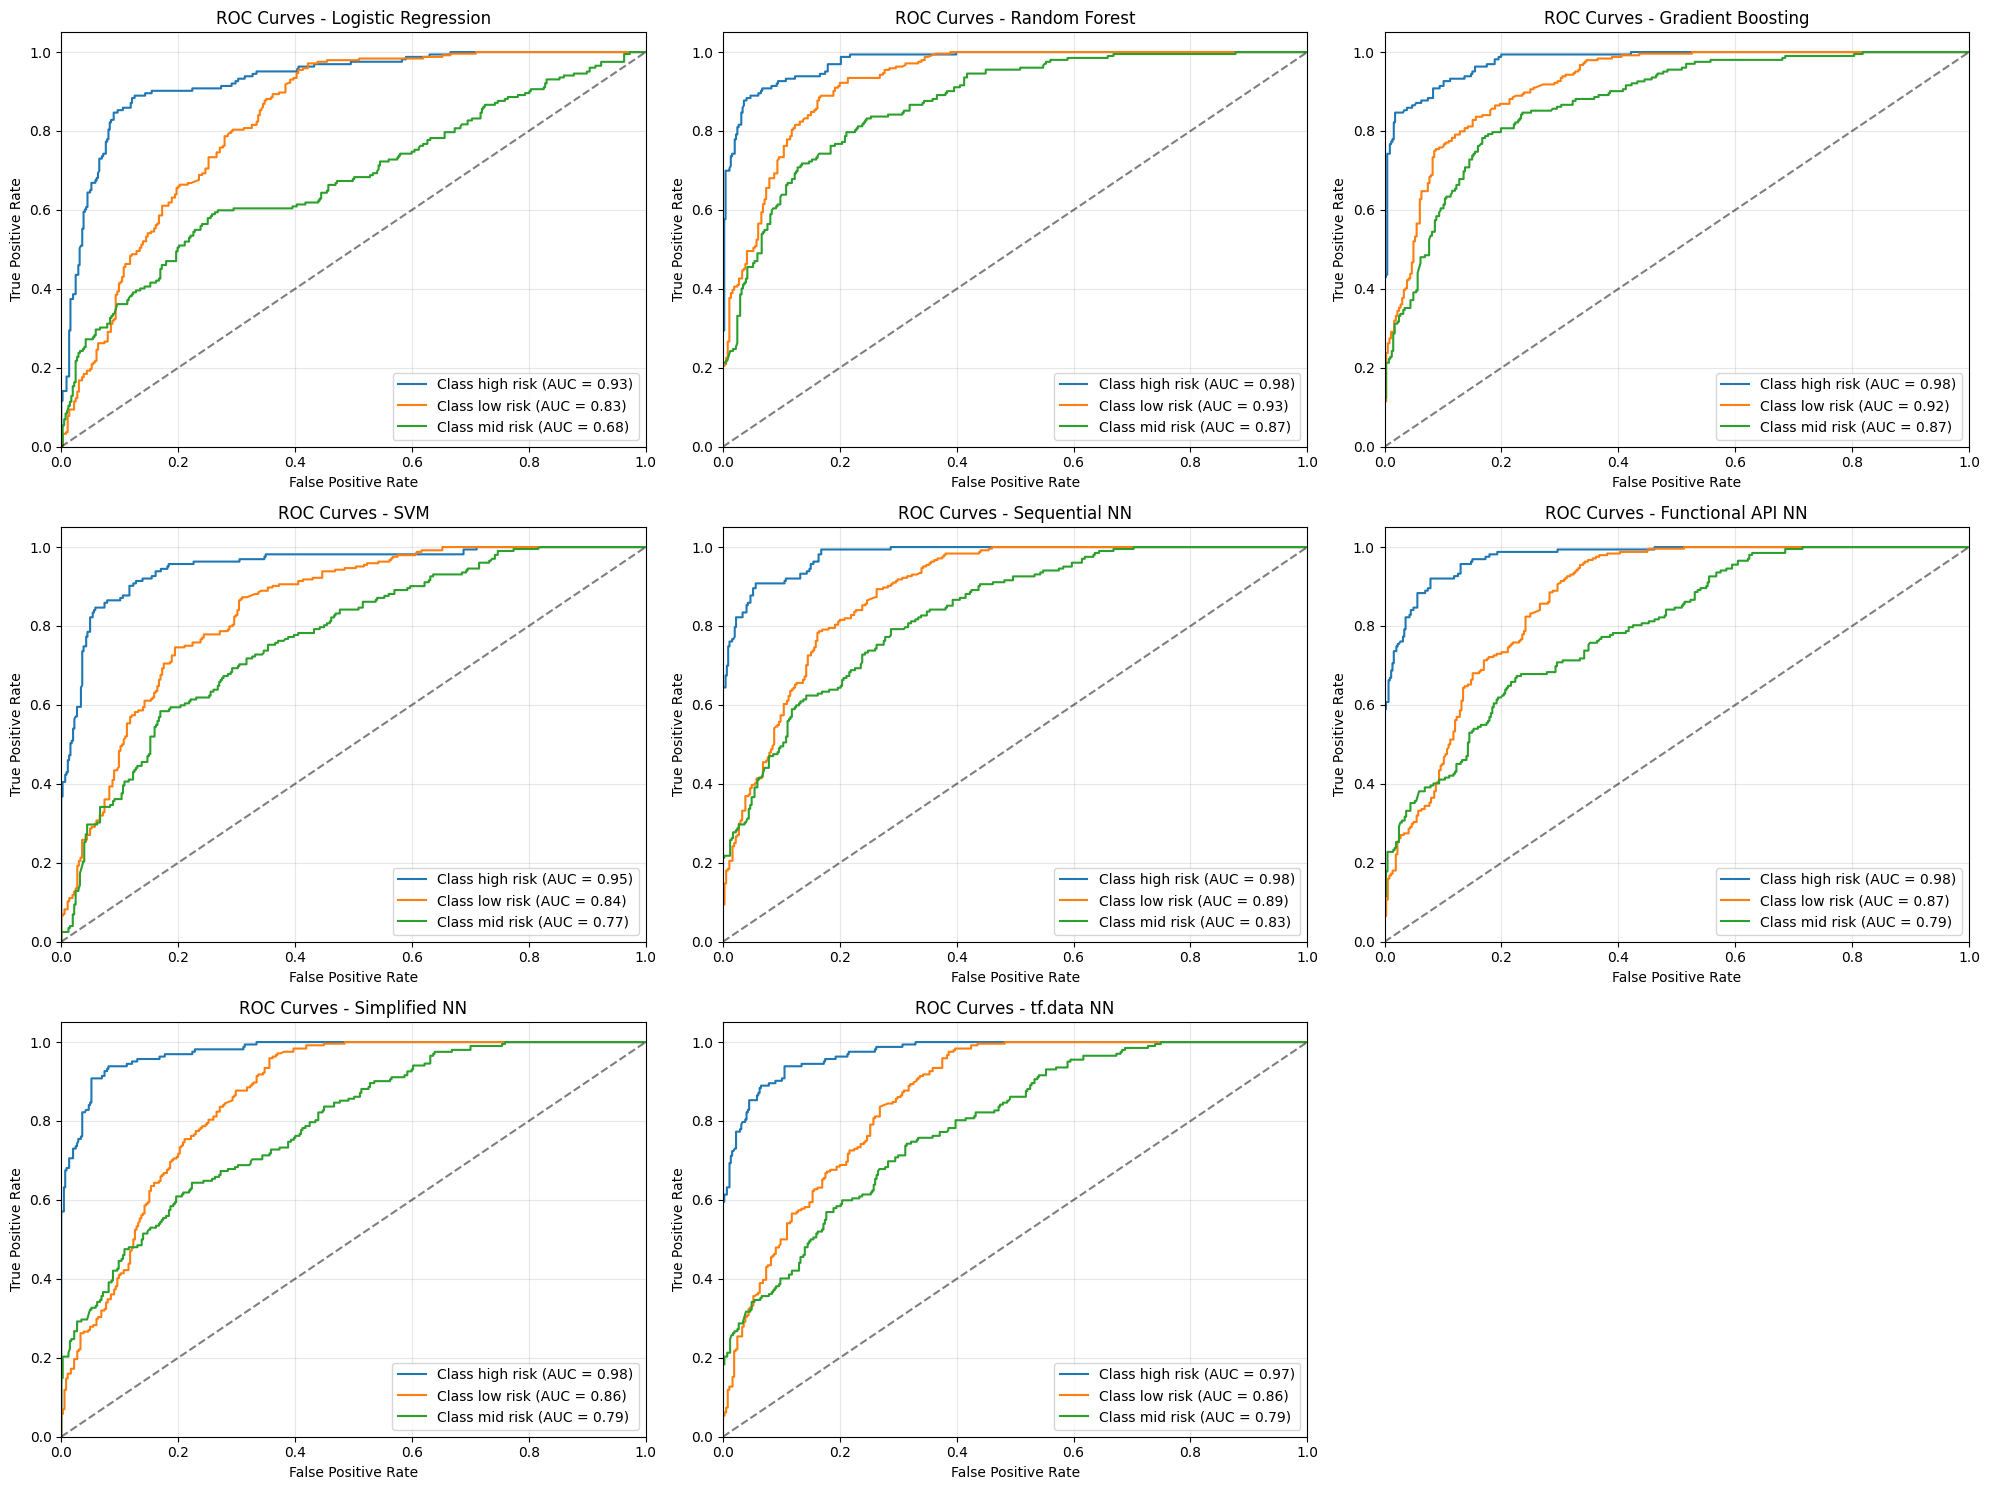

In [29]:
# ROC Curves for All Models
num_models = len(all_results)
num_cols = 3
num_rows = (num_models + num_cols - 1) // num_cols # Calculate required rows

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5)) # Adjust figsize

# Flatten axes array if necessary
if num_rows == 1 and num_cols == 1:
    axes = np.array([axes])
elif num_rows == 1 or num_cols == 1:
    axes = axes.flatten()
else:
    axes = axes.flatten()


for i, (model_name, results) in enumerate(all_results.items()):
    if 'probabilities' in results:
        # One-vs-Rest ROC curve
        fpr = {}
        tpr = {}
        roc_auc = {}

        for class_idx in range(3):
            fpr[class_idx], tpr[class_idx], _ = roc_curve(
                (y_test == class_idx).astype(int),
                results['probabilities'][:, class_idx]
            )
            roc_auc[class_idx] = roc_auc_score(
                (y_test == class_idx).astype(int),
                results['probabilities'][:, class_idx]
            )

        # Plot ROC curves on the current subplot
        ax = axes[i]
        for class_idx in range(3):
            ax.plot(fpr[class_idx], tpr[class_idx],
                    label=f'Class {target_encoder.classes_[class_idx]} (AUC = {roc_auc[class_idx]:.2f})')

        ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'ROC Curves - {model_name}')
        ax.legend(loc="lower right")
        ax.grid(True, alpha=0.3)

# Remove any unused subplots
for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes[j])


plt.tight_layout()
plt.show()